In [2]:
import numpy as np 
import matplotlib.pyplot as plt

### BEAT MODEL

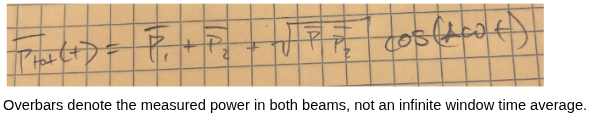

### 150 MHz PD MODEL PARAMS
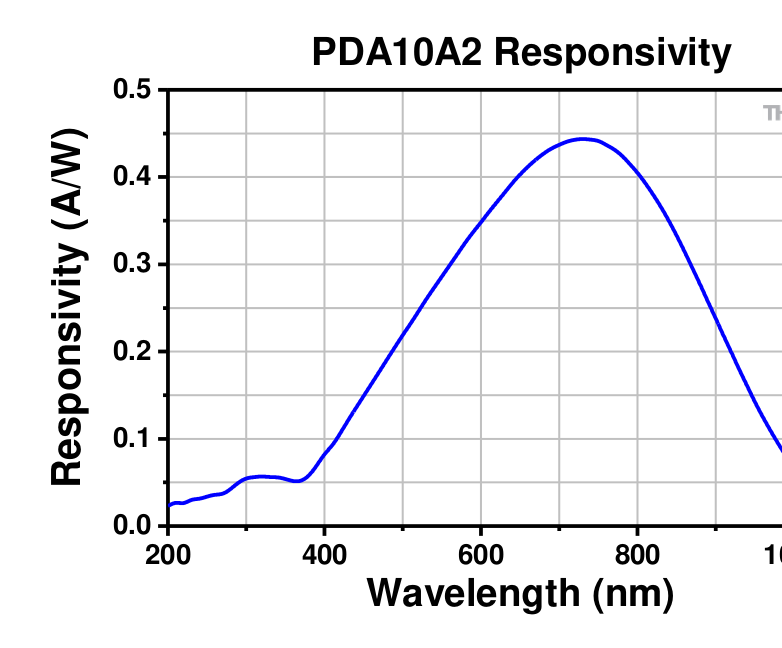
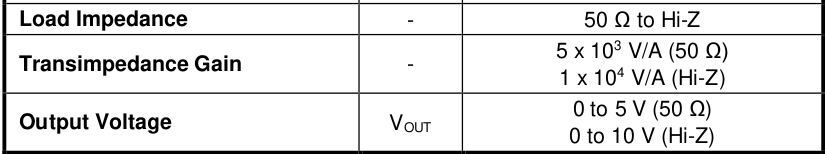

In [3]:
PD_RESP_150 = .3 # A/W
TRANS_GAIN_150 = 1e4  # Hi-Z figure

In [ ]:
def pd_pwr2Vpp(pwr1,pwr2,pd_resp,term_R):
    pwr_dc = pwr1+pwr2
    pwr_pp = 2 * np.sqrt(pwr1*pwr2)
    dmg = pwr_dc + pwr_pp/2
    if np.any(dmg > 18e-3):
        raise ValueError("WARNING: PD MAX POWER THRESHOLD (18mW) EXCEEDED")

    pwr2V = pd_resp * term_R
    max_v = pwr_dc * pwr2V + (pwr_pp * pwr2V/2)
    if np.any(max_v > 2):
        raise ValueError("WARNING: PD MAX OUTPUT VOLTAGE THRESHOLD (2V) EXCEEDED")
    
    return pwr_dc * pwr2V, pwr_pp * pwr2V

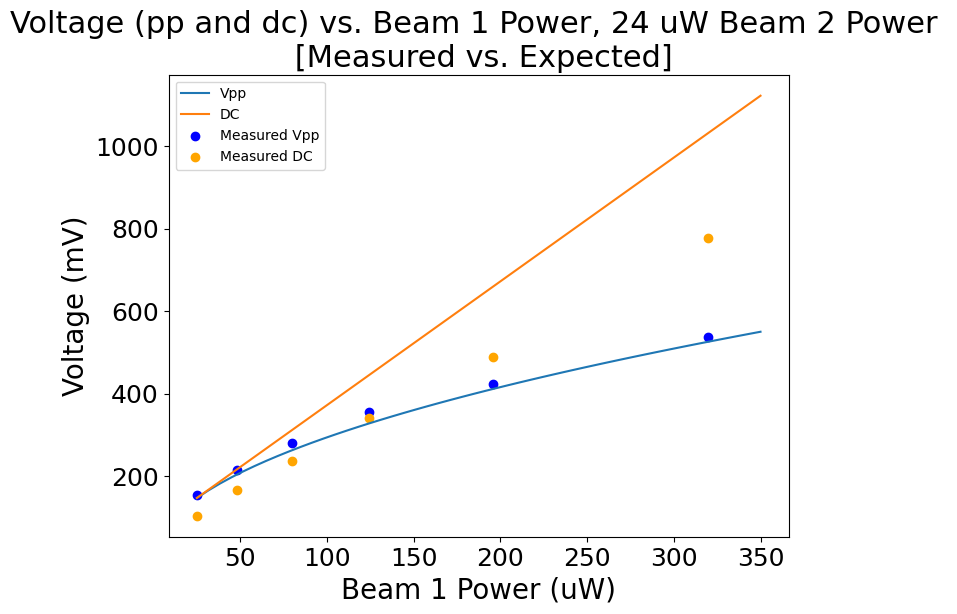

In [27]:
# verifying theory using what we saw # 
pwr_dat = np.array([25, 48, 80, 124, 196, 320])*1e-6 
vdc_dat = np.array([104, 166, 236, 340, 488, 776])*1e-3
vpp_dat = np.array([154, 216, 280, 356, 424, 536])*1e-3

pwr1_range = np.linspace(25e-6, 350e-6, 50) # W
pwr2_set = 24e-6 # W 

dc, vpp = pd_pwr2Vpp(pwr1_range, pwr2_set, PD_RESP_150, TRANS_GAIN_150)


plt.plot(pwr1_range * 1e6, vpp * 1e3, label='Vpp')
plt.plot(pwr1_range * 1e6, dc * 1e3, label='DC')
plt.scatter(pwr_dat * 1e6, vpp_dat * 1e3, color='blue', label='Measured Vpp')
plt.scatter(pwr_dat * 1e6, vdc_dat * 1e3, color='orange', label='Measured DC')
plt.xlabel('Beam 1 Power (uW)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage (pp and dc) vs. Beam 1 Power, 24 uW Beam 2 Power \n [Measured vs. Expected]')
plt.legend()

### 2GHz PD MODEL PARAMS
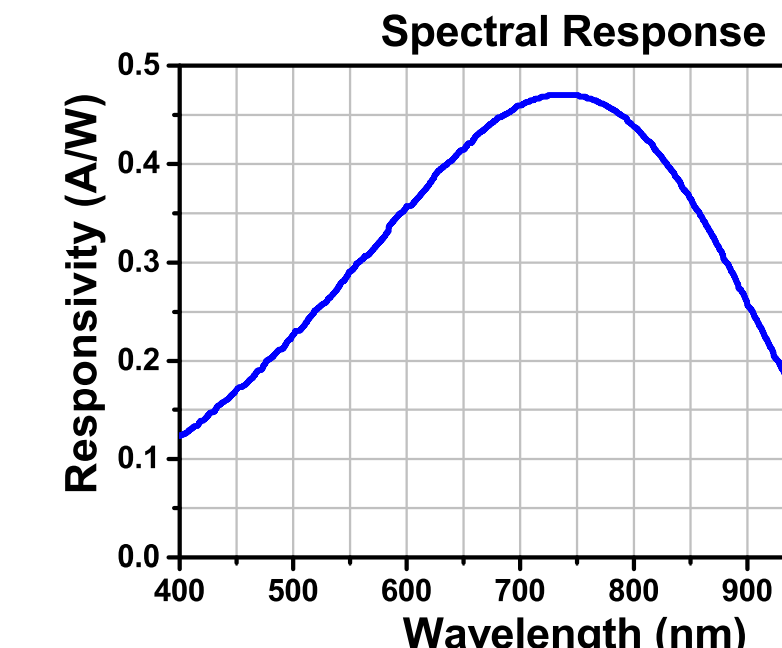
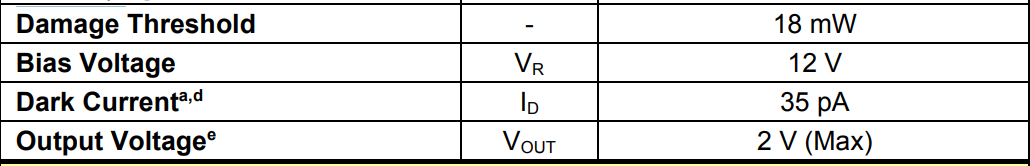

We will never exceed dmg thresh

In [28]:
PD_RESP_2G = .3 # A/W
TRANS_GAIN_2G = 50 # 50 Ohm Load gives us standard Vpp measurement which we can convert to pwr

In [29]:
def vpp2vrms(vpp):
    return vpp / (2**0.5 * 2)

def vrms2dbm(vrms, load=50): # 50 Ohm default load
    pwr = vrms**2/load
    return 10 * np.log10(pwr / 1e-3)

def dbm2vpp(dbm, z=50):
    prms = 10**(dbm/10) * 1e-3
    vrms = np.sqrt(prms * z)
    vpp = vrms * np.sqrt(2) * 2
    return vpp

In [30]:
in1_pwr = 5e-3
in2_pwr = 5e-3
total_pwr = in1_pwr + in2_pwr

TRANS_GAIN_2G = 50 # 50 Ohms Standard

dc, vpp = pd_pwr2Vpp(in1_pwr, in2_pwr, PD_RESP_2G, TRANS_GAIN_2G)
# rms = vpp2vrms(pp)

print(f'Beam 1 pwr: {in1_pwr*1e3:.1f} mW,                         Beam 2 pwr: {in2_pwr*1e3:.1f} mW')
print(f'Total power: {total_pwr*1e3:.1f} mW (PD Max power = 18 mW)')
if total_pwr > 18e-3:
    print('WARNING: DAMAGE THRESHOLD EXCEEDED')  # Never gonna happen with 20 mW total in and maximum 50% efficiency
print('------------------------------------------------------------------------------')
print(f'{TRANS_GAIN_2G} Ohm load, {PD_RESP_2G:.2f} A/W PD response @ 556 nm')
print(f'Vpp: {vpp*1e3:.0f} mV, dBm: {vrms2dbm(vpp2vrms(vpp), load=50):.1f} dBm')
print(f'DC offset: {dc*1e3:.0f} mV, Max Voltage Peak: {(dc+vpp/2) * 1e3:.0f} mV, Photodiode Max Rated Voltage: 2 V')

Beam 1 pwr: 5.0 mW,                         Beam 2 pwr: 5.0 mW
Total power: 10.0 mW (PD Max power = 18 mW)
------------------------------------------------------------------------------
50 Ohm load, 0.30 A/W PD response @ 556 nm
Vpp: 150 mV, dBm: -12.5 dBm
DC offset: 150 mV, Max Voltage Peak: 225 mV, Photodiode Max Rated Voltage: 2 V


### ELECTRONICS MODEL

In [76]:
BEAM1_MAX_PWR = 6e-3 # not quite 10 mW just to be a little careful
BEAM2_MAX_PWR = 6e-3

BEAM1_AT_PD_RAW = 0.5 * BEAM1_MAX_PWR
BEAM2_AT_PD_RAW = 0.25 * BEAM2_MAX_PWR

BEAM1_AT_PD_AOM = BEAM1_AT_PD_RAW * 0.08
BEAM2_AT_PD_AOM = BEAM2_AT_PD_RAW
print(BEAM1_AT_PD_AOM*1E3, 'mW', BEAM2_AT_PD_AOM*1e3, 'mW')

0.24000000000000002 mW 1.5 mW


Now using "AOM" for modeling how to avoid damaging the div by 24 freq prescaler

In [99]:
BEAM1_AT_PD_AOM = .4e-3
BEAM2_AT_PD_AOM =  .5e-3
print(BEAM1_AT_PD_AOM*1E3, 'mW', BEAM2_AT_PD_AOM*1e3, 'mW')

0.4 mW 0.5 mW


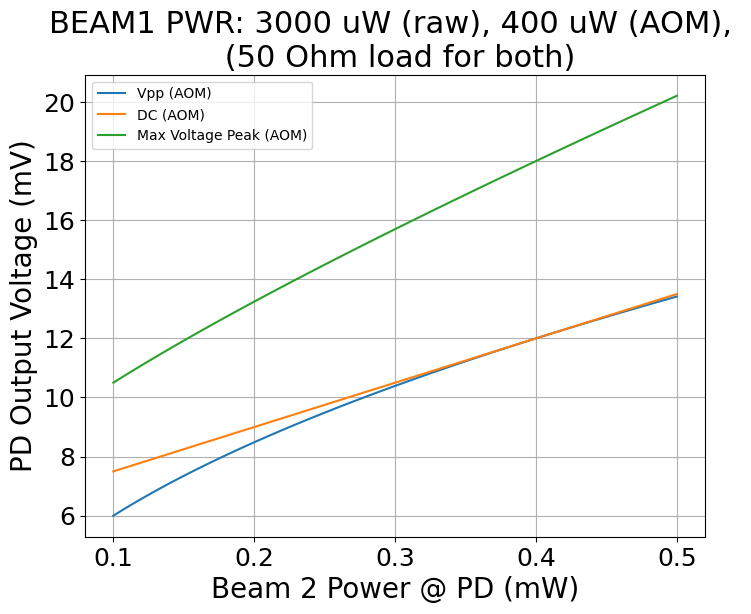

In [100]:
# in1_pwr_raw = BEAM1_AT_PD_RAW
# in2_pwr_raw = np.linspace(0.1e-3, BEAM2_AT_PD_RAW, 100)

in1_pwr_aom = BEAM1_AT_PD_AOM
in2_pwr_aom = np.linspace(0.1e-3, BEAM2_AT_PD_AOM, 100)

# dc_raw, vpp_raw = pd_pwr2Vpp(in1_pwr_raw, in2_pwr_raw, PD_RESP_2G, TRANS_GAIN_2G)
dc_aom, vpp_aom = pd_pwr2Vpp(in1_pwr_aom, in2_pwr_aom, PD_RESP_2G, TRANS_GAIN_2G)

# plt.plot(in2_pwr_raw * 1e3, vpp_raw * 1e3, label='Vpp (Raw)')
# plt.plot(in2_pwr_raw * 1e3, dc_raw * 1e3, label='DC (Raw)')
# plt.plot(in2_pwr_raw * 1e3, (dc_raw + vpp_raw/2) * 1e3, label='Max Voltage Peak (Raw)')

plt.plot(in2_pwr_aom * 1e3, vpp_aom * 1e3, label='Vpp (AOM)')
plt.plot(in2_pwr_aom * 1e3, dc_aom * 1e3, label='DC (AOM)')
plt.plot(in2_pwr_aom * 1e3, (dc_aom + vpp_aom/2) * 1e3, label='Max Voltage Peak (AOM)')

plt.xlabel('Beam 2 Power @ PD (mW)')
plt.ylabel('PD Output Voltage (mV)')
plt.title(f'BEAM1 PWR: {BEAM1_AT_PD_RAW*1e6:.0f} uW (raw), {BEAM1_AT_PD_AOM*1e6:.0f} uW (AOM), \n (50 Ohm load for both)')
plt.legend()
plt.grid()

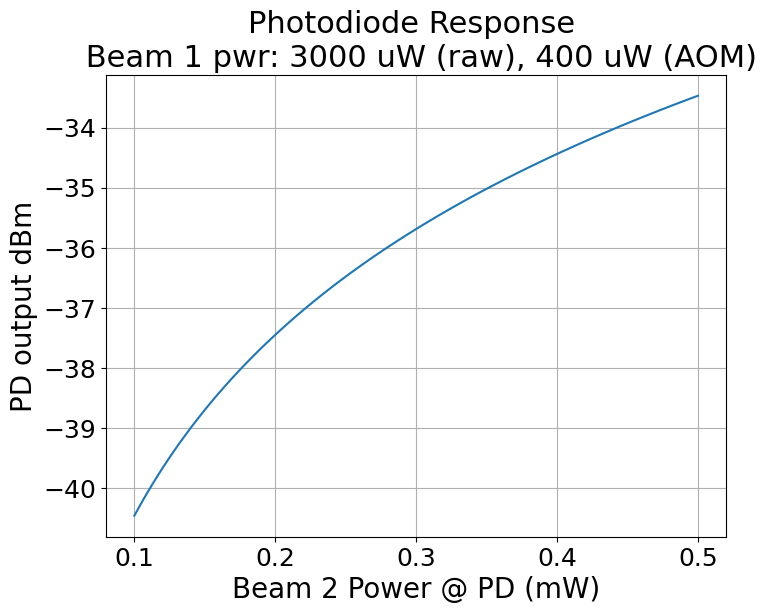

In [101]:
# raw_dbm = vrms2dbm(vpp2vrms(vpp_raw))
aom_dbm = vrms2dbm(vpp2vrms(vpp_aom))

# plt.plot(in2_pwr_raw * 1e3, raw_dbm, label='dBm (Raw)')
plt.plot(in2_pwr_aom * 1e3, aom_dbm, label='dBm (AOM)')
plt.xlabel('Beam 2 Power @ PD (mW)')
plt.ylabel('PD output dBm')
plt.title(f'Photodiode Response \n Beam 1 pwr: {BEAM1_AT_PD_RAW*1e6:.0f} uW (raw), {BEAM1_AT_PD_AOM*1e6:.0f} uW (AOM)')
plt.grid()

In [102]:
# best_raw_pwr = raw_dbm[-1]
best_aom_pwr = aom_dbm[-1]

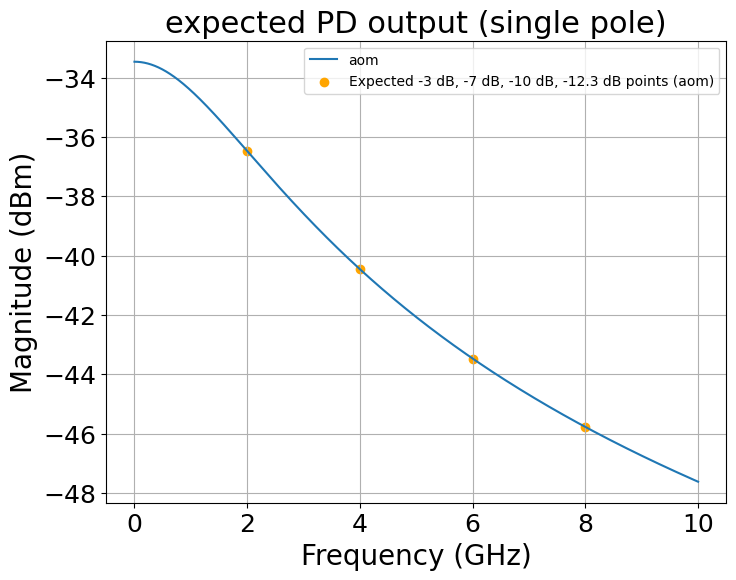

In [103]:
def low_bode(freq, corner):
    # low pass transfer func
    magnitude = 1 / np.sqrt(1 + (freq/corner)**2)
    return 20 * np.log10(magnitude)

freq_range = np.logspace(0, 10, 10001)


tfunc_values = low_bode(freq_range, 2e9)
# raw_tfunc_values = best_raw_pwr + tfunc_values
aom_tfunc_values = best_aom_pwr + tfunc_values

# plt.plot(freq_range/1e9, raw_tfunc_values, label="raw")
plt.plot(freq_range/1e9, aom_tfunc_values, label="aom")
# plt.xscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dBm)')
plt.title('expected PD output (single pole)')
# plt.axvline(x=2, color='black', linestyle='--')
# plt.axvline(x=4, color='black', linestyle='--')
# plt.axvline(x=6, color='black', linestyle='--')
# plt.axvline(x=8, color='black', linestyle='--')
# plt.scatter([2,4,6,8], [best_raw_pwr-3, best_raw_pwr-7, best_raw_pwr-10, best_raw_pwr-12.3], color='blue', label='Expected -3 dB, -7 dB, -10 dB, -12.3 dB points (raw)')
plt.scatter([2,4,6,8], [best_aom_pwr-3, best_aom_pwr-7, best_aom_pwr-10, best_aom_pwr-12.3], color='orange', label='Expected -3 dB, -7 dB, -10 dB, -12.3 dB points (aom)')
plt.legend()
plt.grid()

### SOME EXAMPLE MIXER PASSBAND CONVERSION LOSS PLOTS

<div style="width: 30%;">

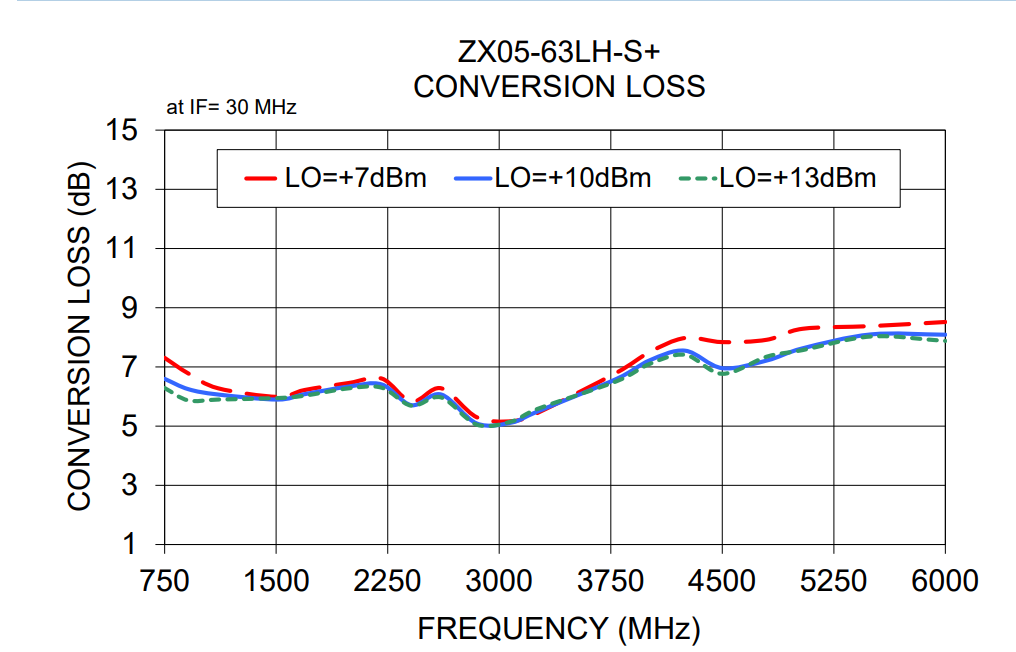

</div> 

<div style="width: 30%;">

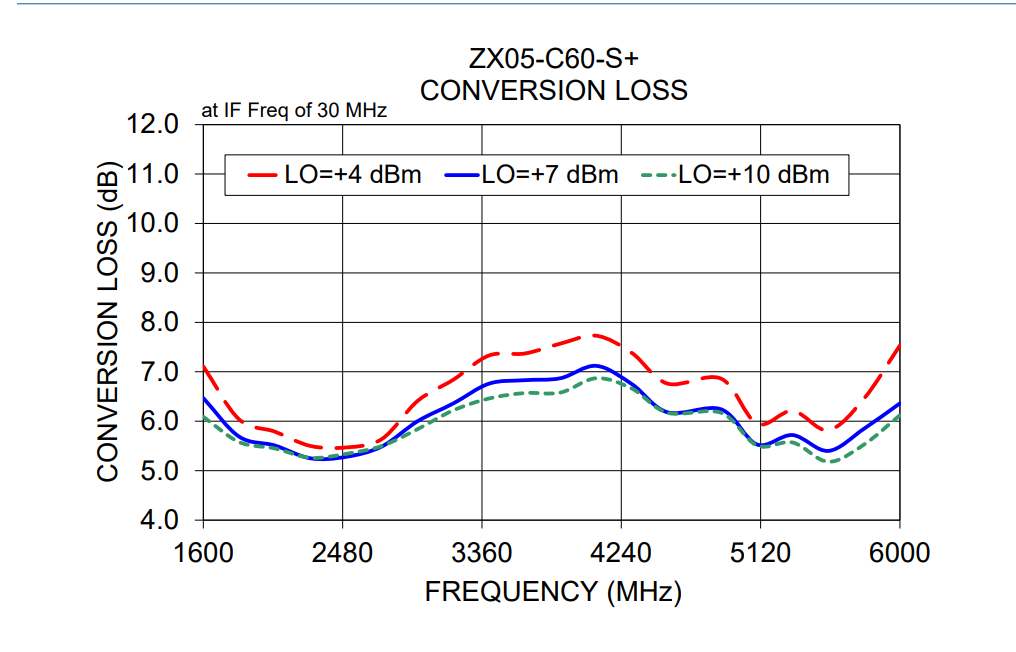

</div>

In [104]:
def mW2dBm(mW):
    return 10 * np.log10(mW)

def high_bode(freq, corner):
    # high pass transfer func
    s = 1j * freq
    h = (s / (s + corner))
    return 20 * np.log10(np.abs(h))

def band_pass_bode(freq, cl, ch):
    high_pass = high_bode(freq, cl)
    low_pass = low_bode(freq, ch)
    return high_pass + low_pass

def component_bandpass(freq, input, fl, fh, gain, compression_pt, damage_pt):
    # models a component block as a bandpass + some gain/insertion loss, + nonlinear clipping + warning for damage
    out = band_pass_bode(freq, fl, fh) + gain + input
    if np.any(input > damage_pt):
        print("WARNING: INPUT DAMAGE THRESHOLD EXCEEDED")
    if np.any(out > compression_pt):
        print("NOTE: Output exceeds compression point, clipping applied")
    out = np.where(out > compression_pt, compression_pt, out)
    return out

### PREAMP COMPRESSION PT AND GAIN
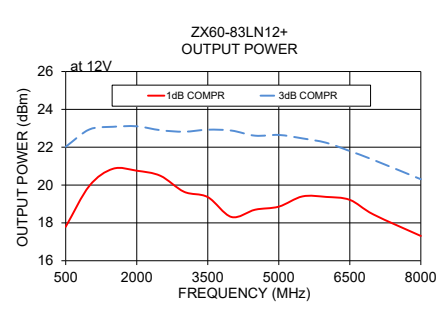

In [105]:
preamp_gain = 22 #dB
preamp_1dB_comp = 20 #dBm
preamp_damage_threshold = 16 #dBm (INPUT)
preamp_bw = [.5e9,8e9]
# preamp_out_raw = component_bandpass(freq_range, raw_tfunc_values, preamp_bw[0], preamp_bw[1], 22, preamp_1dB_comp, preamp_damage_threshold)
preamp_out_aom = component_bandpass(freq_range, aom_tfunc_values, preamp_bw[0], preamp_bw[1], 22, preamp_1dB_comp, preamp_damage_threshold)

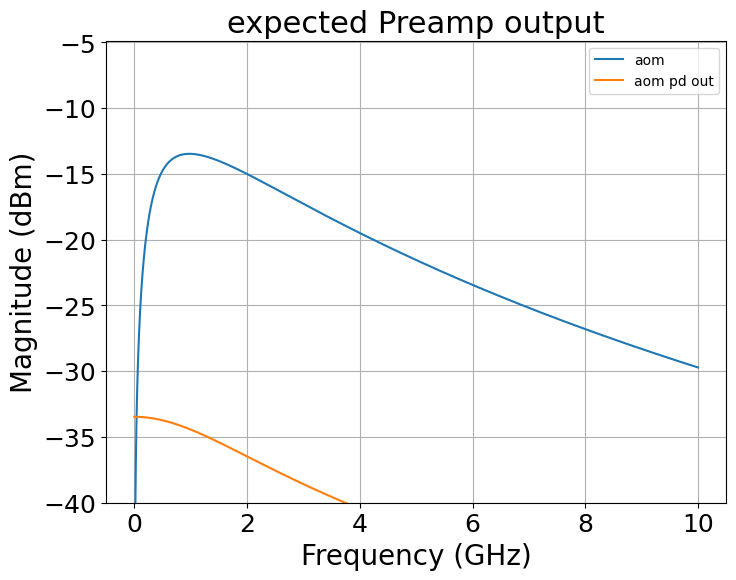

In [106]:
# plt.plot(freq_range/1e9, preamp_out_raw, label="raw")
plt.plot(freq_range/1e9, preamp_out_aom, label="aom")
# plt.plot(freq_range/1e9, raw_tfunc_values, label="raw pd out")
plt.plot(freq_range/1e9, aom_tfunc_values, label="aom pd out")
plt.ylim(bottom=-40)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dBm)')
plt.title('expected Preamp output')
plt.legend()
plt.grid()

### Div. by 24 Freq. Prescaler min to max pwr input: -20 to 10 dBm

### Mixer Losses

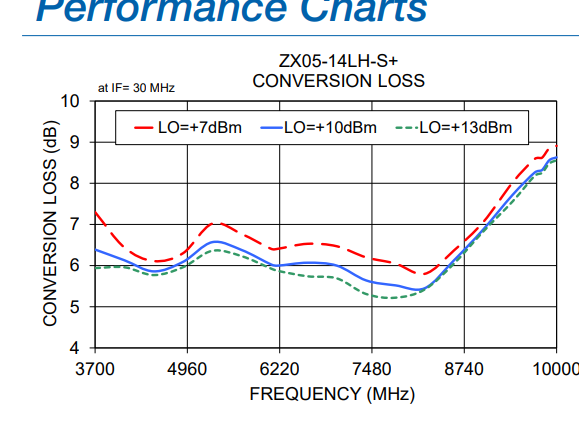

VCO has 8-13.5 dBm power out so is perfect for this mixer

In [74]:
mixer_a_bw = [3.7e9, 10e9]
mixer_a_dmg_t = mW2dBm(50)  # 50 mW threshold
mixer_a_1dB_comp = 5 # compression point (dBm) for the 10 dBm mixer
mixer_a_conv_loss = -6 # conversion loss (dB)
mixer_a_out_raw = component_bandpass(freq_range, preamp_out_raw, mixer_a_bw[0], mixer_a_bw[1], mixer_a_conv_loss, mixer_a_1dB_comp, mixer_a_dmg_t)
mixer_a_out_aom = component_bandpass(freq_range, preamp_out_aom, mixer_a_bw[0], mixer_a_bw[1], mixer_a_conv_loss, mixer_a_1dB_comp, mixer_a_dmg_t)

NameError: name 'preamp_out_raw' is not defined

In [75]:
plt.plot(freq_range/1e9, preamp_out_raw, label="raw")
plt.plot(freq_range/1e9, preamp_out_aom, label="aom")
plt.plot(freq_range/1e9, mixer_a_out_raw, label="raw mix out")
plt.plot(freq_range/1e9, mixer_a_out_aom, label="aom mix out")
plt.ylim(bottom=-40)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude (dBm)')
plt.title('expected Mixer output (3.7-10GHz)')
plt.legend()
plt.grid()

NameError: name 'preamp_out_raw' is not defined

### freq axis downconversion

In [321]:
def down_conv_freq(freq_range, lo_f):
    return np.abs(freq_range - lo_f)

down_range_4 = down_conv_freq(freq_range, 4e9)
down_range_6 = down_conv_freq(freq_range, 6e9)
down_range_8 = down_conv_freq(freq_range, 8e9)  

### Post down conv. amplifier

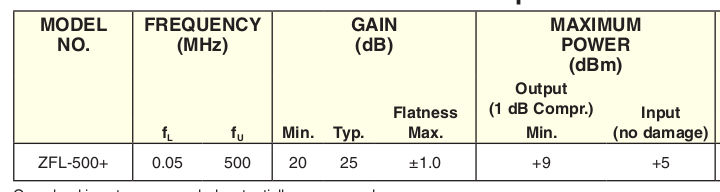

In [322]:
post_amp_bw = [.05e6,500e6]
post_amp_gain = 25 
post_amp_comp = 9 #dbm
post_amp_dmg = 5 # dbm



print('--------------------------------------')
print("RAW")
zfl500_4_raw = component_bandpass(down_range_4, mixer_a_out_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_6_raw = component_bandpass(down_range_6, mixer_a_out_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_8_raw = component_bandpass(down_range_8, mixer_a_out_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)

print('--------------------------------------')
print('2X RAW')
zfl500_4_raw_2x = component_bandpass(down_range_4, zfl500_4_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_6_raw_2x = component_bandpass(down_range_6, zfl500_6_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_8_raw_2x = component_bandpass(down_range_8, zfl500_8_raw, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)

print('--------------------------------------')
print('AOM')

zfl500_4_aom = component_bandpass(down_range_4, mixer_a_out_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_6_aom = component_bandpass(down_range_6, mixer_a_out_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
zfl500_8_aom = component_bandpass(down_range_8, mixer_a_out_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)


print('-------------------------------------')
print('DOUBLE AMPLIFICATION OF AOM')
aom_2x_amp_4 = component_bandpass(down_range_4, zfl500_4_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
aom_2x_amp_6 = component_bandpass(down_range_6, zfl500_6_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)
aom_2x_amp_8 = component_bandpass(down_range_8, zfl500_8_aom, post_amp_bw[0], post_amp_bw[1], post_amp_gain, post_amp_comp, post_amp_dmg)   



--------------------------------------
RAW
NOTE: Output exceeds compression point, clipping applied
--------------------------------------
2X RAW
NOTE: Output exceeds compression point, clipping applied
NOTE: Output exceeds compression point, clipping applied
NOTE: Output exceeds compression point, clipping applied
--------------------------------------
AOM
-------------------------------------
DOUBLE AMPLIFICATION OF AOM
NOTE: Output exceeds compression point, clipping applied
NOTE: Output exceeds compression point, clipping applied
NOTE: Output exceeds compression point, clipping applied


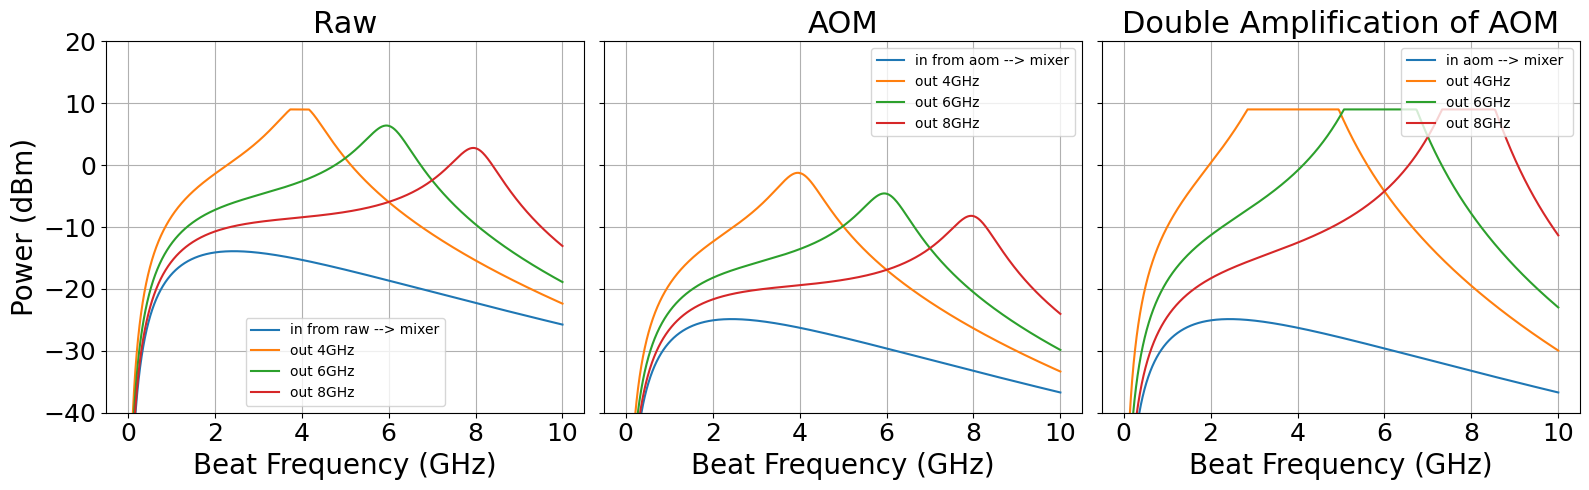

In [323]:
fig, ax = plt.subplots(1,3, figsize=(16,5), sharey=True)

ax[0].plot(freq_range/1e9, mixer_a_out_raw, label="in from raw --> mixer")
ax[0].plot(freq_range/1e9, zfl500_4_raw, label="out 4GHz")
ax[0].plot(freq_range/1e9, zfl500_6_raw, label="out 6GHz")
ax[0].plot(freq_range/1e9, zfl500_8_raw, label="out 8GHz")
ax[0].set_title("Raw")
ax[0].legend()
ax[0].set_xlabel("Beat Frequency (GHz)")
ax[0].set_ylabel("Power (dBm)")
ax[0].set_ylim(-40, 20)
ax[0].grid()

ax[1].plot(freq_range/1e9, mixer_a_out_aom, label="in from aom --> mixer")
ax[1].plot(freq_range/1e9, zfl500_4_aom, label="out 4GHz")
ax[1].plot(freq_range/1e9, zfl500_6_aom, label="out 6GHz")
ax[1].plot(freq_range/1e9, zfl500_8_aom, label="out 8GHz")
ax[1].set_title("AOM")
ax[1].legend()
ax[1].set_xlabel("Beat Frequency (GHz)")
ax[1].grid()


ax[2].plot(freq_range/1e9, mixer_a_out_aom, label="in aom --> mixer ")
ax[2].plot(freq_range/1e9, aom_2x_amp_4, label="out 4GHz")
ax[2].plot(freq_range/1e9, aom_2x_amp_6, label="out 6GHz")
ax[2].plot(freq_range/1e9, aom_2x_amp_8, label="out 8GHz")
ax[2].set_title("Double Amplification of AOM")
ax[2].legend()
ax[2].set_xlabel("Beat Frequency (GHz)")
ax[2].grid()

plt.tight_layout()


### Bi-Directional Coupler
the one we have:

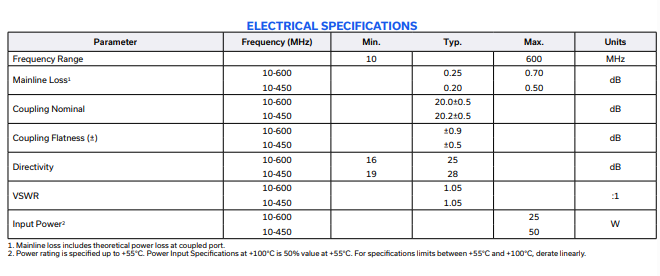

### Power Splitter
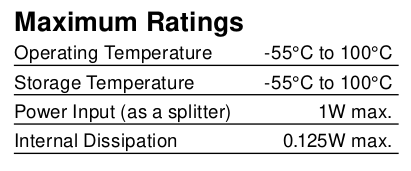
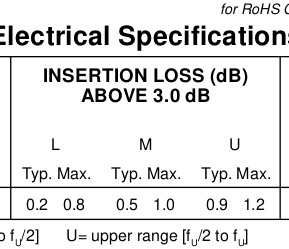

In [324]:
bi_d_coupler_bw = [5e6, 1200e6] # the one we want
coupler_main_loss = -1 # dB
coupler_sample_loss = -13 # dB
coupler_dmg = mW2dBm(1e3)  # 1 W threshold never going to hit that 
coupler_1db = coupler_dmg # no compression cause its just two transmission lines lol

raw_main_coupled_out_4 = component_bandpass(down_range_4, zfl500_4_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)
raw_main_coupled_out_6 = component_bandpass(down_range_6, zfl500_6_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)
raw_main_coupled_out_8 = component_bandpass(down_range_8, zfl500_8_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)

raw_sample_coupled_out_4 = component_bandpass(down_range_4, zfl500_4_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)
raw_sample_coupled_out_6 = component_bandpass(down_range_6, zfl500_6_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)
raw_sample_coupled_out_8 = component_bandpass(down_range_8, zfl500_8_raw, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)

aom_main_coupled_out_4 = component_bandpass(down_range_4, aom_2x_amp_4, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)
aom_main_coupled_out_6 = component_bandpass(down_range_6, aom_2x_amp_6, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)
aom_main_coupled_out_8 = component_bandpass(down_range_8, aom_2x_amp_8, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_main_loss, coupler_1db, coupler_dmg)

aom_sample_coupled_out_4 = component_bandpass(down_range_4, aom_2x_amp_4, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)
aom_sample_coupled_out_6 = component_bandpass(down_range_6, aom_2x_amp_6, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)
aom_sample_coupled_out_8 = component_bandpass(down_range_8, aom_2x_amp_8, bi_d_coupler_bw[0], bi_d_coupler_bw[1], coupler_sample_loss, coupler_1db, coupler_dmg)


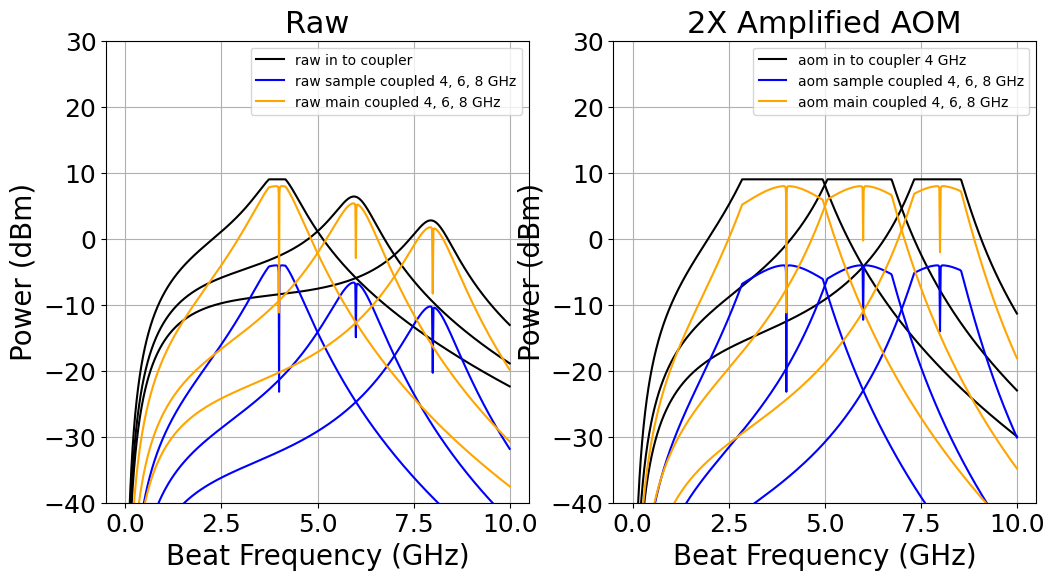

In [325]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].plot(freq_range/1e9, zfl500_4_raw, color='black',label="raw in to coupler")
ax[0].plot(freq_range/1e9, zfl500_6_raw, color='black')
ax[0].plot(freq_range/1e9, zfl500_8_raw, color='black')
ax[0].plot(freq_range/1e9, raw_sample_coupled_out_4, color='blue',label="raw sample coupled 4, 6, 8 GHz")
ax[0].plot(freq_range/1e9, raw_sample_coupled_out_6, color='blue')
ax[0].plot(freq_range/1e9, raw_sample_coupled_out_8, color='blue')
ax[0].plot(freq_range/1e9, raw_main_coupled_out_4, color='orange', label="raw main coupled 4, 6, 8 GHz")
ax[0].plot(freq_range/1e9, raw_main_coupled_out_6, color='orange')
ax[0].plot(freq_range/1e9, raw_main_coupled_out_8, color='orange')
ax[0].set_title("Raw")
ax[0].set_xlabel("Beat Frequency (GHz)")
ax[0].set_ylabel("Power (dBm)")
ax[0].set_ylim(-40, 30)
ax[0].legend()
ax[0].grid()

ax[1].plot(freq_range/1e9, aom_2x_amp_4, color='black',label="aom in to coupler 4 GHz")
ax[1].plot(freq_range/1e9, aom_2x_amp_6, color='black')
ax[1].plot(freq_range/1e9, aom_2x_amp_8, color='black')
ax[1].plot(freq_range/1e9, aom_sample_coupled_out_4, color='blue',label="aom sample coupled 4, 6, 8 GHz")
ax[1].plot(freq_range/1e9, aom_sample_coupled_out_6, color='blue')
ax[1].plot(freq_range/1e9, aom_sample_coupled_out_8, color='blue')
ax[1].plot(freq_range/1e9, aom_main_coupled_out_4, color='orange', label="aom main coupled 4, 6, 8 GHz")
ax[1].plot(freq_range/1e9, aom_main_coupled_out_6, color='orange')
ax[1].plot(freq_range/1e9, aom_main_coupled_out_8, color='orange')
ax[1].set_title("2X Amplified AOM")
ax[1].set_xlabel("Beat Frequency (GHz)")
ax[1].set_ylabel("Power (dBm)")
ax[1].set_ylim(-40, 30)
ax[1].legend()
ax[1].grid()


In [326]:
p_split_bw = [.2e6, 1000e6]
p_split_loss = -3.2 # dB
p_split_dmg = mW2dBm(1e3)  # 1 W threshold, dont have to worry abt that until ~ 30dBm
p_split_1db = p_split_dmg # no compression again cause passive

AOM_p_split_out_4 = component_bandpass(down_range_4, aom_main_coupled_out_4, p_split_bw[0], p_split_bw[1], p_split_loss, p_split_1db, p_split_dmg)
AOM_p_split_out_6 = component_bandpass(down_range_6, aom_main_coupled_out_6, p_split_bw[0], p_split_bw[1], p_split_loss, p_split_1db, p_split_dmg)
AOM_p_split_out_8 = component_bandpass(down_range_8, aom_main_coupled_out_8, p_split_bw[0], p_split_bw[1], p_split_loss, p_split_1db, p_split_dmg)


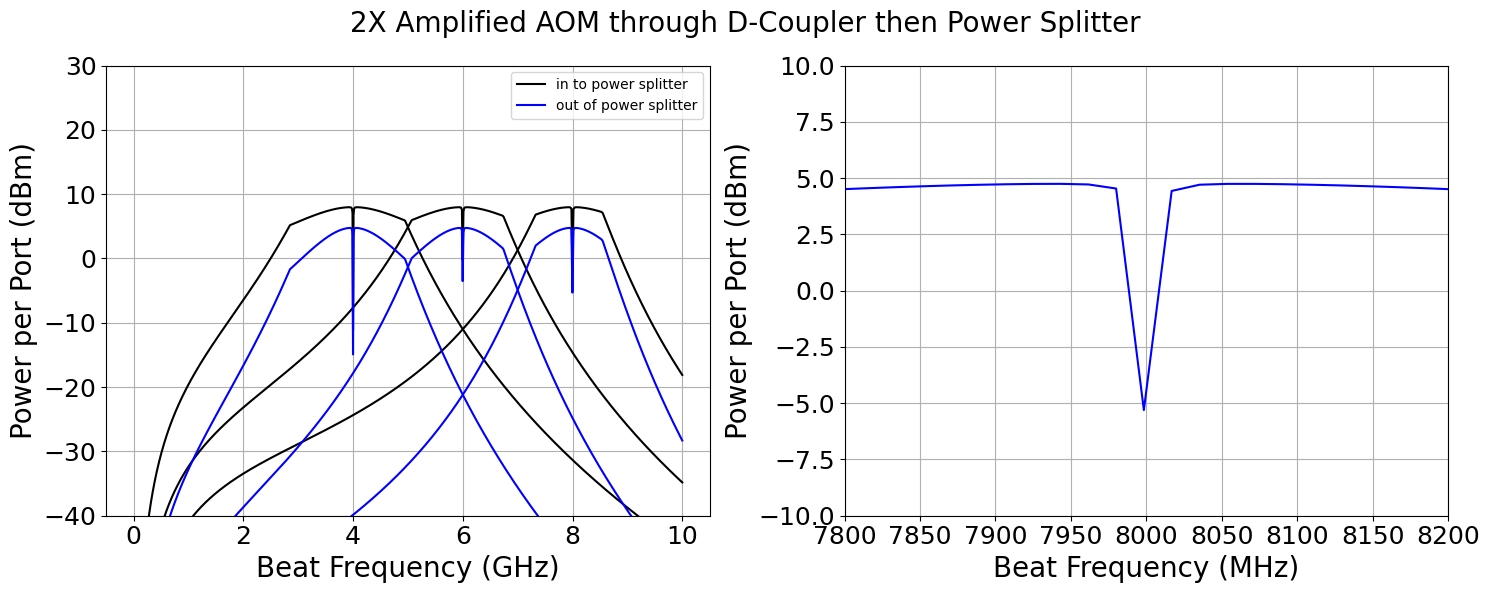

In [327]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(freq_range/1e9, aom_main_coupled_out_4, color='black',label="in to power splitter")
ax[0].plot(freq_range/1e9, aom_main_coupled_out_6, color='black')
ax[0].plot(freq_range/1e9, aom_main_coupled_out_8, color='black')
ax[0].plot(freq_range/1e9, AOM_p_split_out_4, color='blue',label="out of power splitter")
ax[0].plot(freq_range/1e9, AOM_p_split_out_6, color='blue',)
ax[0].plot(freq_range/1e9, AOM_p_split_out_8, color='blue',)
ax[0].set_ylim(-40, 30)
ax[0].set_ylabel("Power per Port (dBm)")
ax[0].set_xlabel("Beat Frequency (GHz)")
ax[0].grid()
ax[0].legend()
fig.suptitle("2X Amplified AOM through D-Coupler then Power Splitter", fontsize=20)

ax[1].plot(freq_range/1e6, AOM_p_split_out_8, color='blue',)
ax[1].set_ylim(-10, 10)
ax[1].set_xlim(7800,8200)
ax[1].set_ylabel("Power per Port (dBm)")
ax[1].set_xlabel("Beat Frequency (MHz)")
ax[1].grid()

fig.tight_layout()

### I think thats enough to drive the Phase Detector (7dBm reccomended)

if neccessary we can run a zad 1 - 1 + mixer at 5 dBm

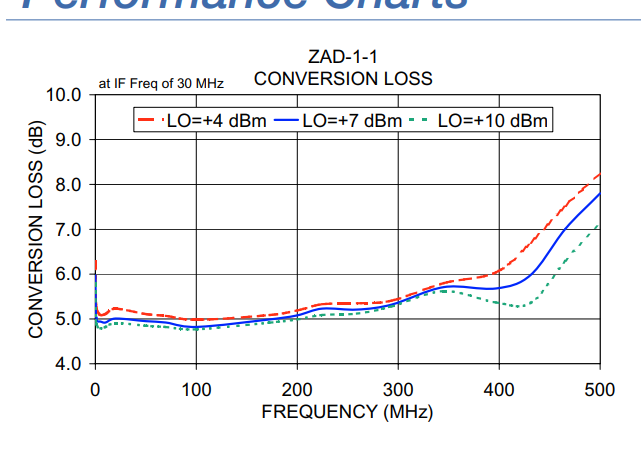

In [293]:
print(dbm2vpp(0, z=50))

0.6324555320336759


In [296]:
phase_det_bw = [1e6, 100e6]
phase_det_loss = -5 # dB is just a guess really
phase_det_dmg = mW2dBm(50)  # 50 mW threshold
phase_det_1db = p_split_dmg # compression meaningless here as Phase det is meant to be run in compression

AOM_phase_out_4 = component_bandpass(down_range_4, AOM_p_split_out_4, phase_det_bw[0], phase_det_bw[1], phase_det_loss, phase_det_1db, phase_det_dmg)
AOM_phase_out_6 = component_bandpass(down_range_6, AOM_p_split_out_6, phase_det_bw[0], phase_det_bw[1], phase_det_loss, phase_det_1db, phase_det_dmg)
AOM_phase_out_8 = component_bandpass(down_range_8, AOM_p_split_out_8, phase_det_bw[0], phase_det_bw[1], phase_det_loss, phase_det_1db, phase_det_dmg)

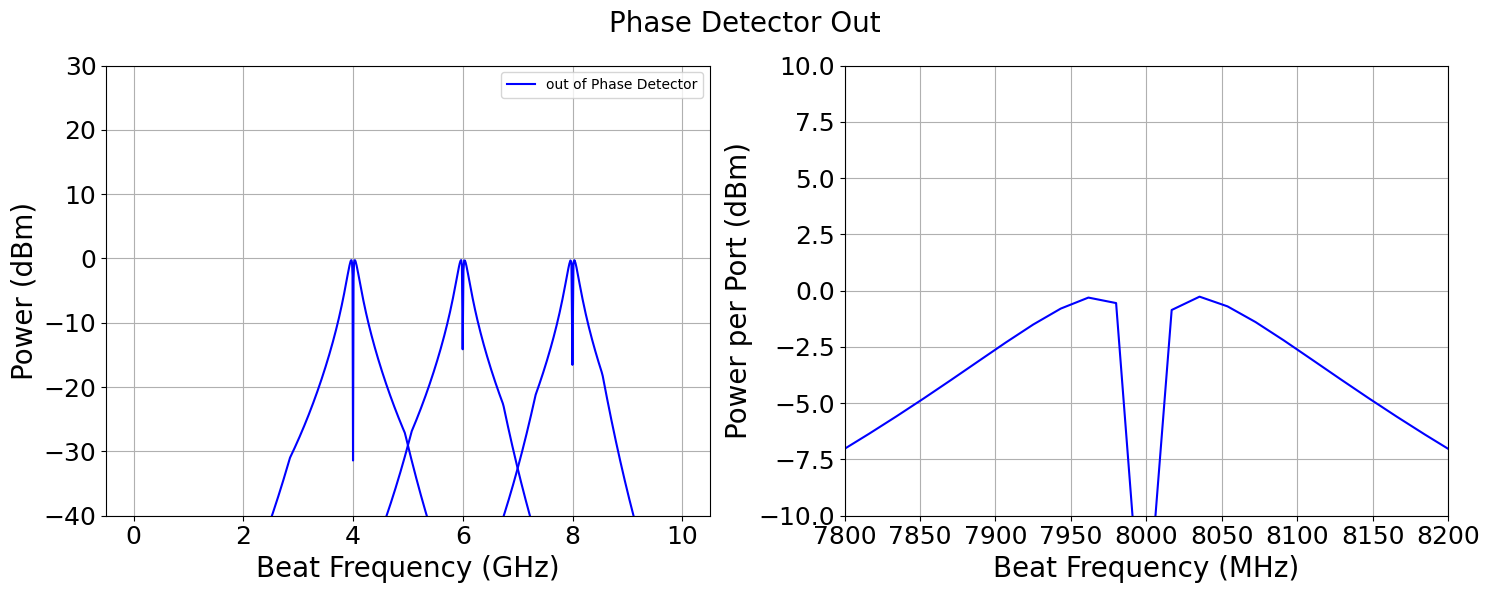

In [298]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].plot(freq_range/1e9, AOM_phase_out_4, color='blue',label="out of Phase Detector")
ax[0].plot(freq_range/1e9, AOM_phase_out_6, color='blue',)
ax[0].plot(freq_range/1e9, AOM_phase_out_8, color='blue',)
ax[0].set_ylim(-40, 30)
ax[0].set_ylabel("Power (dBm)")
ax[0].set_xlabel("Beat Frequency (GHz)")
ax[0].grid()
ax[0].legend()
fig.suptitle("Phase Detector Out", fontsize=20)

ax[1].plot(freq_range/1e6, AOM_phase_out_8, color='blue',)
ax[1].set_ylim(-10, 10)
ax[1].set_xlim(7800,8200)
ax[1].set_ylabel("Power per Port (dBm)")
ax[1].set_xlabel("Beat Frequency (MHz)")
ax[1].grid()

fig.tight_layout()

In [299]:
# Maybe run this whole model on the tested experiments parameters and verify it faithfully reproduces the expected results